# Training a Raspberry Pi to Detect Traffic Signs and People in Real Time

This is tutorial is based on Chengwei's excellent Tutorial and Colab Notebook on ["How to train an object detection model easy for free"](https://www.dlology.com/blog/how-to-train-an-object-detection-model-easy-for-free/).   My twist on his tutorial is that I need to run my model on a Raspberry Pi with live video feed.  As the Raspberry Pi is fairly limited on CPU power and can only run object detection at 1-2 FPS (frames/sec), I have purchased the newly release $75 Google's [EdgeTPU USB Accelarator](https://coral.withgoogle.com/products/accelerator), which can detect objects at 12 FPS, which is sufficient for real time work.  After doing the transfer learning from one of the object detection models using our own images, last few steps of the colab deals with how to convert a trained model to a model file that can be consumed by an Edge TPU, namely, the final `mymodel_quantized_edgetpu.tflite` file.  


![](https://cdn-images-1.medium.com/max/1000/1*_jABdMfUVcyPdi5b3zlfVg.jpeg)



In [1]:
# pip install tensorflow==1.15

In [2]:
import tensorflow
print(tensorflow.__version__)

1.15.0


# Section 1: Mount Google drive
Mount my Google Drive and save modeling output files (`.ckpt`)  there, so that it won't be wiped out when colab Virtual Machine restarts.  It has an idle timeout of 90 min, and maximum daily usage of 12 hours.

Google will ask for an authenticate code when you run the following code, just follow the link in the output and allow access.   You can put the `model_dir` anywhere in your google drive.

In [3]:

from google.colab import drive
drive.mount('/content/gdrive')
model_dir = '/content/gdrive/My Drive/Colab Notebooks/TransfertLearning/Training'
#!rm -rf '{model_dir}'
#os.makedirs(model_dir, exist_ok=True)
!ls -ltra '{model_dir}'/..

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
total 8
drwx------ 2 root root 4096 Mar 14 01:31 training
drwx------ 2 root root 4096 Mar 14 02:55 Training


# Section 2: Configs and Hyperparameters

Support a variety of models, you can find more pretrained model from [Tensorflow detection model zoo: COCO-trained models](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md#coco-trained-models), as well as their pipline config files in [object_detection/samples/configs/](https://github.com/tensorflow/models/tree/master/research/object_detection/samples/configs).

In [4]:
# If you forked the repository, you can replace the link.
repo_url = 'https://github.com/dctian/DeepPiCar'

# Number of training steps.
num_steps = 1000  # 200000
#num_steps = 100  # 200000

# Number of evaluation steps.
num_eval_steps = 50


# model configs are from Model Zoo github: 
# https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md#coco-trained-models
MODELS_CONFIG = {
    #http://download.tensorflow.org/models/object_detection/ssd_mobilenet_v1_quantized_300x300_coco14_sync_2018_07_18.tar.gz
    'ssd_mobilenet_v1_quantized': {
        'model_name': 'ssd_mobilenet_v1_quantized_300x300_coco14_sync_2018_07_18',
        'pipeline_file': 'ssd_mobilenet_v1_quantized_300x300_coco14_sync.config',
        'batch_size': 12
    },    
    'ssd_mobilenet_v2': {
        'model_name': 'ssd_mobilenet_v2_coco_2018_03_29',
        'pipeline_file': 'ssd_mobilenet_v2_coco.config',
        'batch_size': 12
    },
    #http://download.tensorflow.org/models/object_detection/ssd_mobilenet_v2_quantized_300x300_coco_2019_01_03.tar.gz
    'ssd_mobilenet_v2_quantized': {
        'model_name': 'ssd_mobilenet_v2_quantized_300x300_coco_2019_01_03',
        'pipeline_file': 'ssd_mobilenet_v2_quantized_300x300_coco.config',
        'batch_size': 12
    },
    'faster_rcnn_inception_v2': {
        'model_name': 'faster_rcnn_inception_v2_coco_2018_01_28',
        'pipeline_file': 'faster_rcnn_inception_v2_pets.config',
        'batch_size': 12
    },
    'rfcn_resnet101': {
        'model_name': 'rfcn_resnet101_coco_2018_01_28',
        'pipeline_file': 'rfcn_resnet101_pets.config',
        'batch_size': 12
    }
}

# Pick the model you want to use
# Select a model in `MODELS_CONFIG`.
# Note: for Edge TPU, you have to:
# 1) start with a pretrained model from model zoo, such as above 4
# 2) Must be a quantized model, which reduces the model size significantly
selected_model = 'ssd_mobilenet_v2_quantized'

# Name of the object detection model to use.
MODEL = MODELS_CONFIG[selected_model]['model_name']

# Name of the pipline file in tensorflow object detection API.
pipeline_file = MODELS_CONFIG[selected_model]['pipeline_file']

# Training batch size fits in Colabe's Tesla K80 GPU memory for selected model.
batch_size = MODELS_CONFIG[selected_model]['batch_size']

# Section 3: Set up Training Environment

## Clone the `DeepPiCar` repository or your fork.

In [5]:
import os

%cd /content

repo_dir_path = os.path.abspath(os.path.join('.', os.path.basename(repo_url)))

# !git clone {repo_url}
%cd {repo_dir_path}

print('Pull it so that we have the latest code/data')
!git pull

/content
/content/DeepPiCar
Pull it so that we have the latest code/data
Already up to date.


## Install required packages

In [6]:
%cd /content
!git clone --quiet https://github.com/tensorflow/models.git

# !apt-get install -qq protobuf-compiler python-pil python-lxml python-tk

!pip install -q Cython contextlib2 pillow lxml matplotlib

!pip install -q pycocotools

!pip install pillow

!pip install lxml

!pip install tf_slim

!pip install lvis

%cd /content/models/research
!protoc object_detection/protos/*.proto --python_out=.

import os
os.environ['PYTHONPATH'] += ':/content/models/research/:/content/models/research/slim/'

os.environ['PYTHONPATH'] += ":/content/models"

import sys
sys.path.append("/content/models")

!python object_detection/builders/model_builder_test.py

/content
fatal: destination path 'models' already exists and is not an empty directory.
/content/models/research


## Prepare `tfrecord` files

Use the following scripts to generate the `tfrecord` files.

```

In [7]:
%cd {repo_dir_path}/models/object_detection

# Convert train folder annotation xml files to a single csv file,
# generate the `label_map.pbtxt` file to `data/` directory as well.
!python code/xml_to_csv.py -i data/images/train -o data/annotations/train_labels.csv -l data/annotations

# Convert test folder annotation xml files to a single csv.
!python code/xml_to_csv.py -i data/images/test -o data/annotations/test_labels.csv

# Generate `train.record`
!python code/generate_tfrecord.py --csv_input=data/annotations/train_labels.csv --output_path=data/annotations/train.record --img_path=data/images/train --label_map data/annotations/label_map.pbtxt

# Generate `test.record`
!python code/generate_tfrecord.py --csv_input=data/annotations/test_labels.csv --output_path=data/annotations/test.record --img_path=data/images/test --label_map data/annotations/label_map.pbtxt

/content/DeepPiCar/models/object_detection
Successfully converted xml to csv.
Generate `data/annotations/label_map.pbtxt`
Successfully converted xml to csv.


W0314 11:56:32.659802 139941438420864 module_wrapper.py:139] From code/generate_tfrecord.py:107: The name tf.python_io.TFRecordWriter is deprecated. Please use tf.io.TFRecordWriter instead.


W0314 11:56:32.698498 139941438420864 module_wrapper.py:139] From code/generate_tfrecord.py:53: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.

Successfully created the TFRecords: /content/DeepPiCar/models/object_detection/data/annotations/train.record


W0314 11:56:35.093808 139660499871616 module_wrapper.py:139] From code/generate_tfrecord.py:107: The name tf.python_io.TFRecordWriter is deprecated. Please use tf.io.TFRecordWriter instead.


W0314 11:56:35.103508 139660499871616 module_wrapper.py:139] From code/generate_tfrecord.py:53: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.

In [8]:
test_record_fname = repo_dir_path + '/models/object_detection/data/annotations/test.record'
train_record_fname = repo_dir_path + '/models/object_detection/data/annotations/train.record'
label_map_pbtxt_fname = repo_dir_path + '/models/object_detection/data/annotations/label_map.pbtxt'

In [9]:
!cat data/annotations/test_labels.csv

filename,width,height,class,xmin,ymin,xmax,ymax
DSC_0013_1615652001817.JPG,640,480,green light,69,29,111,132
DSC_0013_1615652001817.JPG,640,480,person,133,155,198,300
DSC_0013_1615652001817.JPG,640,480,50 speed sign,224,73,271,129
DSC_0013_1615652001817.JPG,640,480,person,314,213,363,313
DSC_0013_1615652001817.JPG,640,480,person,357,129,407,253
DSC_0013_1615652001817.JPG,640,480,green light,427,12,452,111
DSC_0030_1615651982129.JPG,640,480,30 speed sign,111,65,166,138
DSC_0030_1615651982129.JPG,640,480,red light,284,1,316,100
DSC_0030_1615651982129.JPG,640,480,person,323,210,375,319
DSC_0030_1615651982129.JPG,640,480,stop sign,451,78,506,146
DSC_0007_1615651232219.JPG,640,480,30 speed sign,80,80,128,136
DSC_0007_1615651232219.JPG,640,480,green light,145,33,189,144
DSC_0007_1615651232219.JPG,640,480,stop sign,253,82,292,133
DSC_0007_1615651232219.JPG,640,480,red light,331,29,361,143
DSC_0007_1615651232219.JPG,640,480,50 speed sign,390,74,426,121


## Download base model

In [10]:
%cd /content/models/research

import os
import shutil
import glob
import urllib.request
import tarfile
MODEL_FILE = MODEL + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'
DEST_DIR = '/content/models/research/pretrained_model'

if not (os.path.exists(MODEL_FILE)):
    urllib.request.urlretrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)

tar = tarfile.open(MODEL_FILE)
tar.extractall()
tar.close()

os.remove(MODEL_FILE)
if (os.path.exists(DEST_DIR)):
    shutil.rmtree(DEST_DIR)
os.rename(MODEL, DEST_DIR)

/content/models/research


In [11]:
!echo {DEST_DIR}
!ls -alh {DEST_DIR}

/content/models/research/pretrained_model
total 204M
drwx------  2 303230 5000 4.0K Jan  4  2019 .
drwxr-xr-x 24 root   root 4.0K Mar 14 11:56 ..
-rw-------  1 303230 5000  93M Jan  4  2019 model.ckpt.data-00000-of-00001
-rw-------  1 303230 5000  68K Jan  4  2019 model.ckpt.index
-rw-------  1 303230 5000  20M Jan  4  2019 model.ckpt.meta
-rw-------  1 303230 5000 4.3K Jan  4  2019 pipeline.config
-rw-------  1 303230 5000  24M Jan  4  2019 tflite_graph.pb
-rw-------  1 303230 5000  68M Jan  4  2019 tflite_graph.pbtxt


In [12]:
fine_tune_checkpoint = os.path.join(DEST_DIR, "model.ckpt")
fine_tune_checkpoint

'/content/models/research/pretrained_model/model.ckpt'

# Section 4: Transfer Learning Training

## Configuring a Training Pipeline

In [13]:
import os
pipeline_fname = os.path.join('/content/models/research/object_detection/samples/configs/', pipeline_file)

assert os.path.isfile(pipeline_fname), '`{}` not exist'.format(pipeline_fname)

In [14]:
def get_num_classes(pbtxt_fname):
    from object_detection.utils import label_map_util
    label_map = label_map_util.load_labelmap(pbtxt_fname)
    categories = label_map_util.convert_label_map_to_categories(
        label_map, max_num_classes=90, use_display_name=True)
    category_index = label_map_util.create_category_index(categories)
    return len(category_index.keys())

In [15]:
import re

# training pipeline file defines:
# - pretrain model path
# - the train/test sets
# - ID to Label mapping and number of classes
# - training batch size
# - epochs to trains
# - learning rate
# - etc

# note we just need to use a sample one, and make edits to it.

num_classes = get_num_classes(label_map_pbtxt_fname)
with open(pipeline_fname) as f:
    s = f.read()
with open(pipeline_fname, 'w') as f:
    
    # fine_tune_checkpoint: downloaded pre-trained model checkpoint path
    s = re.sub('fine_tune_checkpoint: ".*?"',
               'fine_tune_checkpoint: "{}"'.format(fine_tune_checkpoint), s)
    
    # tfrecord files train and test, we created earlier with our training/test sets
    s = re.sub(
        '(input_path: ".*?)(train.record)(.*?")', 'input_path: "{}"'.format(train_record_fname), s)
    s = re.sub(
        '(input_path: ".*?)(val.record)(.*?")', 'input_path: "{}"'.format(test_record_fname), s)

    # label_map_path: ID to label file
    s = re.sub(
        'label_map_path: ".*?"', 'label_map_path: "{}"'.format(label_map_pbtxt_fname), s)

    # Set training batch_size.
    s = re.sub('batch_size: [0-9]+',
               'batch_size: {}'.format(batch_size), s)

    # Set training steps, num_steps (Number of epochs to train)
    s = re.sub('num_steps: [0-9]+',
               'num_steps: {}'.format(num_steps), s)
    
    # Set number of classes num_classes.
    s = re.sub('num_classes: [0-9]+',
               'num_classes: {}'.format(num_classes), s)
    f.write(s)

In [16]:
!cat {label_map_pbtxt_fname}

item {
    id: 1
    name: '30 speed sign'
}

item {
    id: 2
    name: '50 speed sign'
}

item {
    id: 3
    name: 'green light'
}

item {
    id: 4
    name: 'person'
}

item {
    id: 5
    name: 'red light'
}

item {
    id: 6
    name: 'stop sign'
}

In [17]:
# look for num_classes: 6, since we have 5 different road signs and 1 person type (total of 6 types) 
!cat {pipeline_fname}

# Quantized trained SSD with Mobilenet v2 on MSCOCO Dataset.
# Users should configure the fine_tune_checkpoint field in the train config as
# well as the label_map_path and input_path fields in the train_input_reader and
# eval_input_reader. Search for "PATH_TO_BE_CONFIGURED" to find the fields that
# should be configured.

model {
  ssd {
    num_classes: 6
    box_coder {
      faster_rcnn_box_coder {
        y_scale: 10.0
        x_scale: 10.0
        height_scale: 5.0
        width_scale: 5.0
      }
    }
    matcher {
      argmax_matcher {
        matched_threshold: 0.5
        unmatched_threshold: 0.5
        ignore_thresholds: false
        negatives_lower_than_unmatched: true
        force_match_for_each_row: true
      }
    }
    similarity_calculator {
      iou_similarity {
      }
    }
    anchor_generator {
      ssd_anchor_generator {
        num_layers: 6
        min_scale: 0.2
        max_scale: 0.95
        aspect_ratios: 1.0
        aspect_ratios: 2.0
        aspe

## Run Tensorboard(Optional)

In [48]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip -o ngrok-stable-linux-amd64.zip

--2021-03-14 05:28:37--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 3.217.26.81, 52.1.26.21, 35.175.47.233, ...
Connecting to bin.equinox.io (bin.equinox.io)|3.217.26.81|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13773305 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip.1’

ngrok-stable-linux- 100%[===================>]  13.13M  36.6MB/s    in 0.4s    

2021-03-14 05:28:38 (36.6 MB/s) - ‘ngrok-stable-linux-amd64.zip.1’ saved [13773305/13773305]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [49]:
LOG_DIR = model_dir
get_ipython().system_raw(
    'tensorboard --logdir "{}" --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

In [50]:
get_ipython().system_raw('./ngrok http 6006 &')

### Get Tensorboard link

In [51]:
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

https://4e52b002fb9e.ngrok.io


## Train the model

Now all inputs are set up, just train the model.   This process may take a few hours.   Since we are saving the model training results (model.ckpt-* files) in our google drive (a persistent storage that will survice the restart of our colab VM instance), we can safely leave and return a few hours later. 

In [18]:
num_steps = 2000

!python /content/models/research/object_detection/model_main.py \
    --pipeline_config_path={pipeline_fname} \
    --model_dir='{model_dir}' \
    --alsologtostderr \
    --num_train_steps={num_steps} \
    --num_eval_steps={num_eval_steps}

W0314 11:58:08.703709 140389739071360 model_lib.py:813] Forced number of epochs for all eval validations to be 1.
INFO:tensorflow:Maybe overwriting train_steps: 2000
I0314 11:58:08.703992 140389739071360 config_util.py:552] Maybe overwriting train_steps: 2000
INFO:tensorflow:Maybe overwriting use_bfloat16: False
I0314 11:58:08.704111 140389739071360 config_util.py:552] Maybe overwriting use_bfloat16: False
INFO:tensorflow:Maybe overwriting sample_1_of_n_eval_examples: 1
I0314 11:58:08.704205 140389739071360 config_util.py:552] Maybe overwriting sample_1_of_n_eval_examples: 1
INFO:tensorflow:Maybe overwriting eval_num_epochs: 1
I0314 11:58:08.704307 140389739071360 config_util.py:552] Maybe overwriting eval_num_epochs: 1
W0314 11:58:08.704447 140389739071360 model_lib.py:829] Expected number of evaluation epochs is 1, but instead encountered `eval_on_train_input_config.num_epochs` = 0. Overwriting `num_epochs` to 1.
INFO:tensorflow:create_estimator_and_inputs: use_tpu False, export_to_t

In [19]:
!ls -ltra '{model_dir}'

total 705750
-rw------- 1 root root 58558540 Mar 14 03:05 events.out.tfevents.1615691102.ca03be6be944
-rw------- 1 root root 58556085 Mar 14 03:22 events.out.tfevents.1615692163.ca03be6be944
-rw------- 1 root root 58570208 Mar 14 09:39 events.out.tfevents.1615699807.ca03be6be944
-rw------- 1 root root 30134200 Mar 14 11:59 graph.pbtxt
-rw------- 1 root root    68804 Mar 14 12:50 model.ckpt-1814.index
-rw------- 1 root root 75237296 Mar 14 12:50 model.ckpt-1814.data-00000-of-00001
-rw------- 1 root root 16352361 Mar 14 12:50 model.ckpt-1814.meta
-rw------- 1 root root    68804 Mar 14 13:00 model.ckpt-1875.index
-rw------- 1 root root 75237296 Mar 14 13:00 model.ckpt-1875.data-00000-of-00001
-rw------- 1 root root 16352361 Mar 14 13:00 model.ckpt-1875.meta
-rw------- 1 root root    68804 Mar 14 13:10 model.ckpt-1937.index
-rw------- 1 root root 75237296 Mar 14 13:10 model.ckpt-1937.data-00000-of-00001
-rw------- 1 root root 16352361 Mar 14 13:10 model.ckpt-1937.meta
-rw------- 1 root roo

# Section 5: Save and Convert Model Output

## Exporting a Trained Inference Graph
Once your training job is complete, you need to extract the newly trained inference graph, which will be later used to perform the object detection. This can be done as follows:

In [20]:
import os
import re
import numpy as np

output_directory = '%s/fine_tuned_model' % model_dir
os.makedirs(output_directory, exist_ok=True)

In [21]:
lst = os.listdir(model_dir)
# find the last model checkpoint file, i.e. model.ckpt-1000.meta
lst = [l for l in lst if 'model.ckpt-' in l and '.meta' in l]
steps=np.array([int(re.findall('\d+', l)[0]) for l in lst])
last_model = lst[steps.argmax()].replace('.meta', '')

last_model_path = os.path.join(model_dir, last_model)
print(last_model_path)


/content/gdrive/My Drive/Colab Notebooks/TransfertLearning/Training/model.ckpt-2000


In [22]:
!echo creates the frozen inference graph in fine_tune_model
# there is an "Incomplete shape" message.  but we can safely ignore that. 
!python /content/models/research/object_detection/export_inference_graph.py \
    --input_type=image_tensor \
    --pipeline_config_path={pipeline_fname} \
    --output_directory='{output_directory}' \
    --trained_checkpoint_prefix='{last_model_path}'

creates the frozen inference graph in fine_tune_model
Instructions for updating:
Please use `layer.__call__` method instead.
W0314 13:48:17.845797 139830735775616 deprecation.py:323] From /usr/local/lib/python3.7/dist-packages/tf_slim/layers/layers.py:1089: Layer.apply (from tensorflow.python.keras.engine.base_layer) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `layer.__call__` method instead.
INFO:tensorflow:depth of additional conv before box predictor: 0
I0314 13:48:20.474091 139830735775616 convolutional_box_predictor.py:156] depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
I0314 13:48:20.521351 139830735775616 convolutional_box_predictor.py:156] depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
I0314 13:48:20.566894 139830735775616 convolutional_box_predictor.py:156] depth of additional conv before box pred

In [23]:
# https://medium.com/tensorflow/training-and-serving-a-realtime-mobile-object-detector-in-30-minutes-with-cloud-tpus-b78971cf1193
# create the tensorflow lite graph
!python /content/models/research/object_detection/export_tflite_ssd_graph.py \
    --pipeline_config_path={pipeline_fname} \
    --trained_checkpoint_prefix='{last_model_path}' \
    --output_directory='{output_directory}' \
    --add_postprocessing_op=true

Instructions for updating:
Please use `layer.__call__` method instead.
W0314 13:48:49.306841 139963762513792 deprecation.py:323] From /usr/local/lib/python3.7/dist-packages/tf_slim/layers/layers.py:1089: Layer.apply (from tensorflow.python.keras.engine.base_layer) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `layer.__call__` method instead.
INFO:tensorflow:depth of additional conv before box predictor: 0
I0314 13:48:51.856096 139963762513792 convolutional_box_predictor.py:156] depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
I0314 13:48:51.892713 139963762513792 convolutional_box_predictor.py:156] depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
I0314 13:48:51.927653 139963762513792 convolutional_box_predictor.py:156] depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv befo

In [24]:
!echo "CONVERTING frozen graph to quantized TF Lite file..."
!tflite_convert \
  --output_file='{output_directory}/road_signs_quantized.tflite' \
  --graph_def_file='{output_directory}/tflite_graph.pb' \
  --inference_type=QUANTIZED_UINT8 \
  --input_arrays='normalized_input_image_tensor' \
  --output_arrays='TFLite_Detection_PostProcess,TFLite_Detection_PostProcess:1,TFLite_Detection_PostProcess:2,TFLite_Detection_PostProcess:3' \
  --mean_values=128 \
  --std_dev_values=128 \
  --input_shapes=1,300,300,3 \
  --change_concat_input_ranges=false \
  --allow_nudging_weights_to_use_fast_gemm_kernel=true \
  --allow_custom_ops

CONVERTING frozen graph to quantized TF Lite file...
2021-03-14 13:49:10.549001: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2021-03-14 13:49:10.560532: E tensorflow/stream_executor/cuda/cuda_driver.cc:318] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-03-14 13:49:10.560588: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (13a9355f5766): /proc/driver/nvidia/version does not exist
2021-03-14 13:49:10.561033: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2021-03-14 13:49:10.567374: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2299995000 Hz
2021-03-14 13:49:10.567660: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x56505ae00a00 initialized for platform Host (this does not gu

In [25]:
!echo "CONVERTING frozen graph to unquantized TF Lite file..."
!tflite_convert \
  --output_file='{output_directory}/road_signs_float.tflite' \
  --graph_def_file='{output_directory}/tflite_graph.pb' \
  --input_arrays='normalized_input_image_tensor' \
  --output_arrays='TFLite_Detection_PostProcess,TFLite_Detection_PostProcess:1,TFLite_Detection_PostProcess:2,TFLite_Detection_PostProcess:3' \
  --mean_values=128 \
  --std_dev_values=128 \
  --input_shapes=1,300,300,3 \
  --change_concat_input_ranges=false \
  --allow_nudging_weights_to_use_fast_gemm_kernel=true \
  --allow_custom_ops 


CONVERTING frozen graph to unquantized TF Lite file...
2021-03-14 13:49:31.241931: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2021-03-14 13:49:31.253108: E tensorflow/stream_executor/cuda/cuda_driver.cc:318] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-03-14 13:49:31.253178: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (13a9355f5766): /proc/driver/nvidia/version does not exist
2021-03-14 13:49:31.253729: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2021-03-14 13:49:31.260306: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2299995000 Hz
2021-03-14 13:49:31.260575: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55f6f2054a00 initialized for platform Host (this does not 

In [26]:
print(output_directory)
!ls -ltra '{output_directory}'
#pb_fname = os.path.join(os.path.abspath(output_directory), "frozen_inference_graph.pb") # this is main one
pb_fname = os.path.join(os.path.abspath(output_directory), "frozen_inference_graph.pb")  # this is tflite graph
!cp '{label_map_pbtxt_fname}' '{output_directory}'

/content/gdrive/My Drive/Colab Notebooks/TransfertLearning/Training/fine_tuned_model
total 134961
-rw------- 1 root root    23543 Mar 14 13:48 model.ckpt.index
-rw------- 1 root root 18922628 Mar 14 13:48 model.ckpt.data-00000-of-00001
-rw------- 1 root root       77 Mar 14 13:48 checkpoint
-rw------- 1 root root  2232276 Mar 14 13:48 model.ckpt.meta
-rw------- 1 root root 19822860 Mar 14 13:48 frozen_inference_graph.pb
drwx------ 3 root root     4096 Mar 14 13:48 saved_model
-rw------- 1 root root     4192 Mar 14 13:48 pipeline.config
-rw------- 1 root root 19408134 Mar 14 13:48 tflite_graph.pb
-rw------- 1 root root 54192740 Mar 14 13:48 tflite_graph.pbtxt
-rw------- 1 root root  4793408 Mar 14 13:49 road_signs_quantized.tflite
-rw------- 1 root root 18792516 Mar 14 13:49 road_signs_float.tflite


## Run inference test
Test with images in repository `object_detection/data/images/test` directory.

In [27]:
import os
import glob

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = pb_fname
print(PATH_TO_CKPT)

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = label_map_pbtxt_fname

# If you want to test the code with your images, just add images files to the PATH_TO_TEST_IMAGES_DIR.
PATH_TO_TEST_IMAGES_DIR =  os.path.join(repo_dir_path, "models/object_detection/data/images/test")

assert os.path.isfile(pb_fname)
assert os.path.isfile(PATH_TO_LABELS)
TEST_IMAGE_PATHS = glob.glob(os.path.join(PATH_TO_TEST_IMAGES_DIR, "*.JPG"))
assert len(TEST_IMAGE_PATHS) > 0, 'No image found in `{}`.'.format(PATH_TO_TEST_IMAGES_DIR)
print(TEST_IMAGE_PATHS)

/content/gdrive/My Drive/Colab Notebooks/TransfertLearning/Training/fine_tuned_model/frozen_inference_graph.pb
['/content/DeepPiCar/models/object_detection/data/images/test/DSC_0013_1615652001817.JPG', '/content/DeepPiCar/models/object_detection/data/images/test/DSC_0007_1615651232219.JPG', '/content/DeepPiCar/models/object_detection/data/images/test/DSC_0030_1615651982129.JPG']


In [28]:
%cd /content/models/research/object_detection

import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops


# This is needed to display the images.
%matplotlib inline


from object_detection.utils import label_map_util

from object_detection.utils import visualization_utils as vis_util


detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')


label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(
    label_map, max_num_classes=num_classes, use_display_name=True)
category_index = label_map_util.create_category_index(categories)


def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)


def run_inference_for_single_image(image, graph):
    with graph.as_default():
        with tf.Session() as sess:
            # Get handles to input and output tensors
            ops = tf.get_default_graph().get_operations()
            all_tensor_names = {
                output.name for op in ops for output in op.outputs}
            tensor_dict = {}
            for key in [
                'num_detections', 'detection_boxes', 'detection_scores',
                'detection_classes', 'detection_masks'
            ]:
                tensor_name = key + ':0'
                if tensor_name in all_tensor_names:
                    tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
                        tensor_name)
            if 'detection_masks' in tensor_dict:
                # The following processing is only for single image
                detection_boxes = tf.squeeze(
                    tensor_dict['detection_boxes'], [0])
                detection_masks = tf.squeeze(
                    tensor_dict['detection_masks'], [0])
                # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
                real_num_detection = tf.cast(
                    tensor_dict['num_detections'][0], tf.int32)
                detection_boxes = tf.slice(detection_boxes, [0, 0], [
                                           real_num_detection, -1])
                detection_masks = tf.slice(detection_masks, [0, 0, 0], [
                                           real_num_detection, -1, -1])
                detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                    detection_masks, detection_boxes, image.shape[0], image.shape[1])
                detection_masks_reframed = tf.cast(
                    tf.greater(detection_masks_reframed, 0.5), tf.uint8)
                # Follow the convention by adding back the batch dimension
                tensor_dict['detection_masks'] = tf.expand_dims(
                    detection_masks_reframed, 0)
            image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

            # Run inference
            output_dict = sess.run(tensor_dict,
                                   feed_dict={image_tensor: np.expand_dims(image, 0)})

            # all outputs are float32 numpy arrays, so convert types as appropriate
            output_dict['num_detections'] = int(
                output_dict['num_detections'][0])
            output_dict['detection_classes'] = output_dict[
                'detection_classes'][0].astype(np.uint8)
            output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
            output_dict['detection_scores'] = output_dict['detection_scores'][0]
            if 'detection_masks' in output_dict:
                output_dict['detection_masks'] = output_dict['detection_masks'][0]
    return output_dict



/content/models/research/object_detection


Running inferences on ['/content/DeepPiCar/models/object_detection/data/images/test/DSC_0013_1615652001817.JPG', '/content/DeepPiCar/models/object_detection/data/images/test/DSC_0007_1615651232219.JPG', '/content/DeepPiCar/models/object_detection/data/images/test/DSC_0030_1615651982129.JPG']


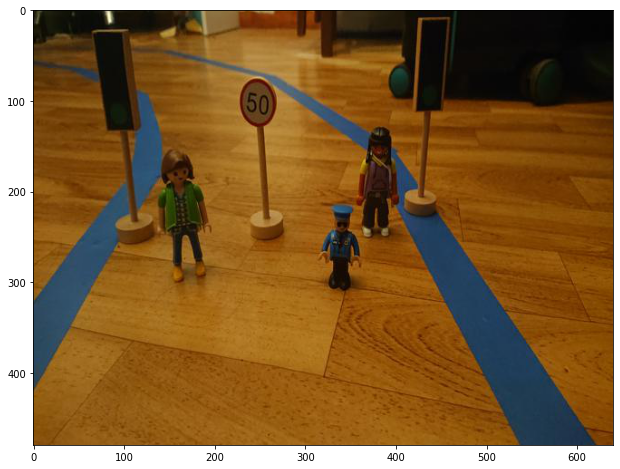

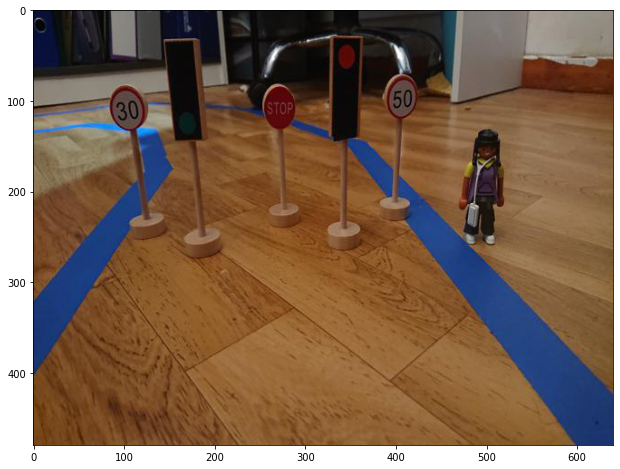

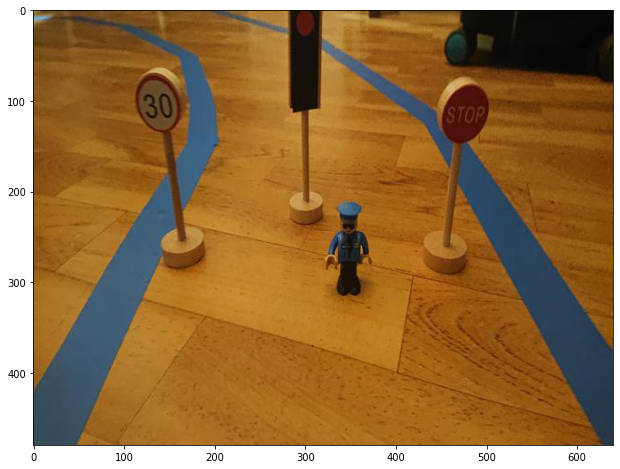

In [29]:
# running inferences.  This should show images with bounding boxes
%matplotlib inline

print('Running inferences on %s' % TEST_IMAGE_PATHS)
for image_path in TEST_IMAGE_PATHS:
    image = Image.open(image_path)
    # the array based representation of the image will be used later in order to prepare the
    # result image with boxes and labels on it.
    image_np = load_image_into_numpy_array(image)
    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_np_expanded = np.expand_dims(image_np, axis=0)
    # Actual detection.
    output_dict = run_inference_for_single_image(image_np, detection_graph)
    # Visualization of the results of a detection.
    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        output_dict['detection_boxes'],
        output_dict['detection_classes'],
        output_dict['detection_scores'],
        category_index,
        instance_masks=output_dict.get('detection_masks'),
        use_normalized_coordinates=True,
        line_thickness=2)
    plt.figure(figsize=IMAGE_SIZE)
    plt.imshow(image_np)

## Convert to Edge TPU's tflite Format  
The only known way, at time of writing (April 2019), is to download the below quantized tflite file from above, and use [Google's web compiler](https://coral.withgoogle.com/web-compiler/) to convert to Edge TPU's tflite format.   Unfortunately, this step has to be done by hand, and NOT via a script.  

Here are the requirements of Edge TPU web compiler.  If you have followed the above steps closely, you have met these requirements.

- Tensor parameters are quantized (8-bit fixed-point numbers). You must use quantization-aware training (post-training quantization is not supported).   (this is why we are using `ssd_mobilenet_v2_quantized` base model and not the  `ssd_mobilenet_v2` base model   
- Tensor sizes are constant at compile-time (no dynamic sizes).
- Model parameters (such as bias tensors) are constant at compile-time.
- Tensors are either 1-, 2-, or 3-dimensional. If a tensor has more than 3 dimensions, then only the 3 innermost dimensions may have a size greater than 1.
- The model uses only the operations supported by the Edge TPU 

In [31]:
# download this file from google drive.
!ls -lt '/content/gdrive/My Drive/Colab Notebooks/TransfertLearning/Training/fine_tuned_model/road_signs_quantized.tflite'

-rw------- 1 root root 4793408 Mar 14 13:49 '/content/gdrive/My Drive/Colab Notebooks/TransfertLearning/Training/fine_tuned_model/road_signs_quantized.tflite'


In [32]:
# download this file from google drive.
!ls -lt '/content/gdrive/My Drive/Colab Notebooks/TransfertLearning/Training/fine_tuned_model/road_signs_quantized_edgetpu.tflite'

-rw------- 1 root root 5411792 Mar 14 14:30 '/content/gdrive/My Drive/Colab Notebooks/TransfertLearning/Training/fine_tuned_model/road_signs_quantized_edgetpu.tflite'


Wait for about 1-2 minutes for compilation to finish.  And we can download the model file as `road_signs_quantized_edgetpu.tflite`.  This is the file you need to copy to raspberry pi with TPU to run object detection.

We are all done with colab notebook training, now time to switch back to raspberry pi, and run `~/DeepPiCar/models/object_detection/code/object_detection_usb.py`.  You should see a video feed where road sign and persons are boxed with confidence level around them.  

```bash
# make sure the the road_signs_quantized_edgetpu.tflite is in the right directory in your pi
pi@raspberrypi:~/DeepPiCar/models/object_detection/data/model_result $ ls -ltr
total 10040
-rw-r--r-- 1 pi pi      97 Apr 15 01:01 road_sign_labels.txt
-rw-r--r-- 1 pi pi 4793504 Apr 16 15:49 road_signs_quantized.tflite
-rw-r--r-- 1 pi pi 5478080 Apr 16 15:49 road_signs_quantized_edgetpu.tflite

pi@raspberrypi:~/DeepPiCar/models/object_detection $ python3 code/object_detection_usb.py

------
2019-04-16 16:22:28.489224: 13.49 FPS, 74.12ms total, 70.84ms in tf 
Green Traffic Light, 80% [[240.61578751 131.68985367]
 [287.21975327 195.79172134]] 60.42ms
Stop Sign, 44% [[  0.         305.1651001 ]
 [180.84949493 409.32563782]] 60.42ms

------
2019-04-16 16:22:28.618309: 14.83 FPS, 67.44ms total, 60.42ms in tf 
Person, 89% [[505.6583786  279.52325821]
 [530.85933685 360.0169754 ]] 62.54ms
Green Traffic Light, 72% [[237.96649933 130.58757782]
 [283.52127075 203.24180603]] 62.54ms
Red Traffic Light, 62% [[283.23583603 169.27398682]
 [330.91316223 269.20692444]] 62.54ms
Stop Sign, 56% [[ 51.01628304 165.80377579]
 [101.48646355 227.05183029]] 62.54ms
Person, 44% [[396.8661499  298.65327835]
 [468.4034729  422.04421997]] 62.54ms
------

```

# Section 6: Last Words on this Project

Of course, depending many factors, not all objects in the video frame will be identified.  This is the chance to improve your model.   Try to train longer, or train with more labeled images, or augment your existing images with different zooms/rotations/contrast/lighting.  In my case, I started with one camera, which was somewhat fuzzy, and precision low.  When I switched to a HD camera, the model precision was significantly better.   This was just another way.

It is awesome that for just over $100 in hardware, we can do real time object detection at home.   Moreover, thanks to Google, all you need is a browser to train this huge model!  Having fun with your own raspberry pi object detection projects!  